In [1]:
# imports
from IPython.display import Image
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.utils.data as torch_data
import numpy as np

In [2]:
from skimage.io import imread_collection
from skimage.io import concatenate_images
coarse_dir = 'drive/MyDrive/coarse_pic/*.jpg'
fine_dir = 'drive/MyDrive/fine_pic/*.jpg'
coarse = imread_collection(coarse_dir)
fine = imread_collection(fine_dir)
fine_data = concatenate_images(fine)
coarse_data = concatenate_images(coarse)
fine_data = fine_data.astype(np.float32)
coarse_data = coarse_data.astype(np.float32)
fine_data = fine_data/255
coarse_data = coarse_data/255

In [3]:
input_size = 400
output_size = 200
bin_size = input_size // output_size
array = x = np.random.randn(160, 200, 200, 3)
for i in range(fine_data.shape[0]):
  array[i,:,:,:] = fine_data[i].reshape((output_size, bin_size, output_size, bin_size, 3)).max(3).max(1)
fine_data = array
fine_data = fine_data.astype(np.float32)

In [4]:
fine_data.shape

(160, 200, 200, 3)

In [5]:
training_fine, test_fine, training_coarse, test_coarse = train_test_split(fine_data, coarse_data, train_size=0.75)

In [6]:
class GridData(torch_data.Dataset):
    def __init__(self, X, Y):
        super(GridData, self).__init__()
        self.X = torch.from_numpy(X)                                                           
        self.Y = torch.from_numpy(Y)
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx].unsqueeze(0), self.Y[idx].unsqueeze(0)

In [7]:
train_input = GridData(training_coarse,training_fine)
test_input = GridData(test_coarse,test_fine)

In [8]:
class AE(nn.Module):
    def __init__(self, encoder, decoder):
        super(AE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, x):
        z = self.encoder(x)
        x_out = self.decoder(z)
        return x_out

In [9]:
ss = 200*200*3
encoder = lambda hid: nn.Sequential(
                        nn.Flatten(),
                        nn.Linear(ss, ss//100),
                        nn.LeakyReLU(inplace=True),
                        nn.Dropout(0.2),
                        nn.Linear(ss//100, ss//1000),
                        nn.LeakyReLU(inplace=True),
                        nn.Dropout(0.2),
                        nn.Linear(ss//1000, hid)
                        ) 

decoder =  lambda hid: nn.Sequential(
                        nn.Linear(hid, ss//1000),
                        nn.LeakyReLU(inplace=True),
                        nn.Dropout(0.2),
                        nn.Linear(ss//1000, ss//100),
                        nn.LeakyReLU(inplace=True),
                        nn.Dropout(0.2),
                        nn.Linear(ss//100, ss),
                        nn.Sigmoid(),
                        ) 

In [10]:
device ='cuda:0'
#device = 'cpu'

net = AE(encoder(70), decoder(70))
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.7)


train_loader = torch_data.DataLoader(train_input, batch_size=225, shuffle=False)  
val_loader = torch_data.DataLoader(test_input, batch_size=65, shuffle=False)

In [11]:
def train(epochs, net, criterion, optimizer, train_loader, val_loader,scheduler=None, verbose=True, save_dir=None):
    net.to(device)
    for epoch in range(1, epochs+1):
        net.train()
        for X,Y in train_loader:
            X = X.to(device)
            Y = Y.to(device)     
            out = net(X)
            m = nn.Flatten()
            loss = criterion(out, m(Y))
            
            optimizer.zero_grad()
            
            loss.backward()
            optimizer.step()

        net.eval()
        for X,Y in val_loader:
            X = X.to(device)
            Y = Y.to(device)
            out = net(X)
            m = nn.Flatten()
            val_loss = criterion(out, m(Y))
         
        if scheduler is not None:
            scheduler.step()
        freq = max(epochs//20,1)
        if verbose and epoch%freq==0:
            print('Epoch {}/{} || Loss:  Train {:.4f} | Validation {:.4f}'.format(epoch, epochs, loss.item(), val_loss.item()))

In [12]:
train(100, net, criterion, optimizer, train_loader, val_loader, scheduler) 

Epoch 5/100 || Loss:  Train 0.0178 | Validation 0.0129
Epoch 10/100 || Loss:  Train 0.0106 | Validation 0.0170
Epoch 15/100 || Loss:  Train 0.0061 | Validation 0.0053
Epoch 20/100 || Loss:  Train 0.0046 | Validation 0.0041
Epoch 25/100 || Loss:  Train 0.0043 | Validation 0.0031
Epoch 30/100 || Loss:  Train 0.0039 | Validation 0.0034
Epoch 35/100 || Loss:  Train 0.0037 | Validation 0.0032
Epoch 40/100 || Loss:  Train 0.0037 | Validation 0.0031
Epoch 45/100 || Loss:  Train 0.0036 | Validation 0.0030
Epoch 50/100 || Loss:  Train 0.0035 | Validation 0.0030
Epoch 55/100 || Loss:  Train 0.0035 | Validation 0.0030
Epoch 60/100 || Loss:  Train 0.0034 | Validation 0.0030
Epoch 65/100 || Loss:  Train 0.0034 | Validation 0.0030
Epoch 70/100 || Loss:  Train 0.0035 | Validation 0.0029
Epoch 75/100 || Loss:  Train 0.0034 | Validation 0.0031
Epoch 80/100 || Loss:  Train 0.0034 | Validation 0.0029
Epoch 85/100 || Loss:  Train 0.0033 | Validation 0.0029
Epoch 90/100 || Loss:  Train 0.0033 | Validation 

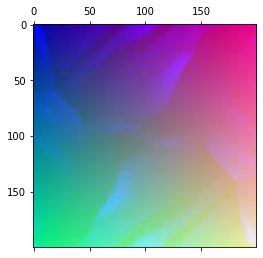

In [13]:
plt.matshow(test_input[3][0][0])

In [14]:
net_result = net(test_input[3][0].to(device)).detach().cpu().reshape(1,200,200,3)

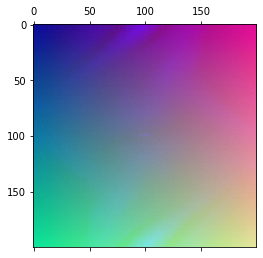

In [15]:
plt.matshow(net_result[0]);

In [16]:
net.encoder(test_input[3][0].to(device)).detach().cpu().shape

torch.Size([1, 70])

In [17]:
acc = []
for k in range(0,len(test_fine)):
  net_result = net(test_input[k][0].to(device)).detach().cpu().reshape(1,200,200,3)
  metric = np.linalg.norm(test_input[k][0][0][:,:,1] - net_result[0][:,:,1])/np.linalg.norm(test_input[k][0][0][:,:,1])
  acc.append(metric)




res = np.array(acc)
print(res.mean())
print()

0.07302364

